<center><h1>VimalaHailson_Damien_HW4</h1></center>
<br>
<br>

<center><font size="10">Damien Vimala Hailson</font></center>
<br><center><font size="6">Github Username: Damien-Hailson</font></center>
<br><center><font size="6">USC ID: 6184971028</font></center>

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
import statsmodels.api as sm
from tabulate import tabulate
import warnings
warnings.simplefilter('ignore')

Get the AReM Data Set

In [2]:
#loading datasets as a dictionary with list of data frame objects under each key (activity name)
folder_names=['bending1','bending2','cycling','lying','sitting','standing','walking']
header_names=['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
datasets={}
for folder in folder_names:
    datasets[folder]=[]
    for k in range(1,16,1):
        try:
            temp_df=pd.read_csv('../Data/AReM/'+folder+'/dataset'+str(k)+'.csv',skiprows=5,header=None,names=header_names,usecols = [0, 1, 2, 3, 4, 5, 6])
            temp_df['activity']=folder
        except:
            continue
        datasets[folder].append(temp_df)

In [3]:
#checking if all datasets are loaded
for a in folder_names:
    b=len(datasets[a])
    print (f"length of {a} is {b}")

length of bending1 is 7
length of bending2 is 6
length of cycling is 15
length of lying is 15
length of sitting is 15
length of standing is 15
length of walking is 15


### (b) Splitting Data

In [4]:
#creating test and training datasets (dictionary with list of pd dataframes as values and activity name as key)
test_datasets={}
train_datasets={}
for activity in folder_names:
    test_datasets[activity]=[]
    train_datasets[activity]=[]
    if activity=='bending1' or activity=='bending2':
        test_datasets[activity].extend(datasets[activity][:2])
        train_datasets[activity].extend(datasets[activity][2:])
    else:
        test_datasets[activity].extend(datasets[activity][:3])
        train_datasets[activity].extend(datasets[activity][3:])                                       

### (c) Feature Extraction

### i.Research

<font size=5>Typically used time domain features are 

<font size=4><br>    1. Mean - Average of values
<font size=4><br>    2. Median - Mid value of datapoints sorted in asending or descending order. Median is normally less sensitive to outliers
<font size=4><br>    3. Standard deviation - measures the dispersion or spread of the data points around the mean
<font size=4><br>    4. Skewness - measures the asymmetry of the distribution of data points around the mean
<font size=4><br>    5. Kurtosis - measures the "peakedness" of the distribution of data points. Higher kurtosis indicates that the data has heavier tails and a sharper peak compared to a normal distribution, while lower kurtosis indicates flatter tails and a more spread-out distribution
<font size=4><br>    6. Range - difference between max and min values of the series
<font size=4><br>    7. Variance - measures the average squared deviation of data points from the mean
<font size=4><br>    8. Interquartile range - The interquartile range is the difference between the upper and lower quartiles (the 75th and 25th percentiles). It provides a measure of the spread of the middle 50% of the data
    
    
<font size=5> In addition to the above statistical time domain features temporal features like the below can be useful too
<font size=4><br> 1.Autocorrelation: Measures the correlation between a time series and a lagged version of itself.
<font size=4><br> 2.Cross-correlation: Measures the similarity between two time series at different time lags.
<font size=4><br> 3.Trend: Indicates the general direction in which the data is moving over time.
<font size=4><br> 4.Seasonality: Captures periodic patterns in the data.
<font size=4><br> 5.Stationarity: Indicates whether the statistical properties of the time series, such as mean and variance, are constant over time.

### ii.extraction

In [5]:
cols = ['min', 'max', 'mean', 'median', 'std', '1st quartile', '3rd quartile']
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
columns = []
for j in range(6):
    for i in range(len(cols)):
        columns.append(cols[i] + str(j+1))
    
parameters = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']
summary=[]
for activity in folder_names:
    for i in range(0,len(datasets[activity]),1):
        temp_list=[]
        stats=datasets[activity][i].describe()
        for series in series_names:
            for parameter in parameters:
                temp_list.append(stats[series][parameter])
        summary.append(temp_list)
summary_df_col_names=[]
for i in range(6):
    for col in cols:
        summary_df_col_names.append(col+str(i+1))
summary_df=pd.DataFrame(summary,columns=summary_df_col_names)       
summary_df

min1   max1      mean1  median1      std1  1st quartile1  3rd quartile1  \
0   37.25  45.00  40.624792    40.50  1.476967          39.25        42.0000   
1   38.00  45.67  42.812812    42.50  1.435550          42.00        43.6700   
2   35.00  47.40  43.954500    44.33  1.558835          43.00        45.0000   
3   33.00  47.75  42.179812    43.50  3.670666          39.15        45.0000   
4   33.00  45.75  41.678063    41.75  2.243490          41.33        42.7500   
..    ...    ...        ...      ...       ...            ...            ...   
83  19.50  45.33  33.586875    34.25  4.650935          30.25        37.0000   
84  19.75  45.50  34.322750    35.25  4.752477          31.00        38.0000   
85  19.50  46.00  34.546229    35.25  4.842294          31.25        37.8125   
86  23.50  46.25  34.873229    35.25  4.531720          31.75        38.2500   
87  19.25  44.00  34.473188    35.00  4.796705          31.25        38.0000   

    min2   max2     mean2  ...      std5  1st quartile5  3rd quartile5  min6  \
0    0.0   1.30  0.358604  ...  2.188449        33.0000          36.00  0.00   
1    0.0   1.22  0.372437  ...  1.995255        32.0000          34.50  0.00   
2    0.0   1.70  0.426250  ...  1.999604        35.3625          36.50  0.00   
3    0.0   3.00  0.696042  ...  3.849448        30.4575          36.33  0.00   
4    0.0   2.83  0.535979  ...  2.411026        28.4575          31.25  0.00   
..   ...    ...       ...  ...       ...            ...            ...   ...   
83   0.0  14.67  4.576562  ...  3.283983        13.7300          18.25  0.00   
84   0.0  13.47  4.456333  ...  3.119856        13.5000          17.75  0.00   
85   0.0  12.47  4.371958  ...  2.823124        14.0000          17.75  0.00   
86   0.0  14.82  4.380583  ...  3.131076        13.7500          18.00  0.00   
87   0.0  13.86  4.359312  ...  3.156320        13.7300          17.75  0.43   

     max6     mean6  median6      std6  1st quartile6  3rd quartile6  
0    1.92  0.570583     0.43  0.582915         0.0000         1.3000  
1    3.11  0.571083     0.43  0.601010         0.0000         1.3000  
2    1.79  0.493292     0.43  0.513506         0.0000         0.9400  
3    2.18  0.613521     0.50  0.524317         0.0000         1.0000  
4    1.79  0.383292     0.43  0.389164         0.0000         0.5000  
..    ...       ...      ...       ...            ...            ...  
83   8.32  3.259729     3.11  1.640243         2.0500         4.3225  
84   9.67  3.432563     3.20  1.732727         2.1575         4.5650  
85  10.00  3.338125     3.08  1.656742         2.1600         4.3350  
86   9.51  3.424646     3.27  1.690960         2.1700         4.5000  
87   9.00  3.340458     3.09  1.699114         2.1200         4.3750  

[88 rows x 42 columns]

### iii.standard deviation

In [6]:
output=[]
for column in summary_df.columns:
    temp=[]
    temp.append(column)
    temp.append(summary_df[column].std())
    output.append(temp)
output_df=pd.DataFrame(output,columns=['Feature','Standard Deviation'])
output_df

Feature  Standard Deviation
0            min1            9.569975
1            max1            4.394362
2           mean1            5.335824
3         median1            5.440054
4            std1            1.772213
5   1st quartile1            6.153590
6   3rd quartile1            5.139414
7            min2            0.000000
8            max2            5.062729
9           mean2            1.574168
10        median2            1.412244
11           std2            0.884105
12  1st quartile2            0.946386
13  3rd quartile2            2.125266
14           min3            2.956462
15           max3            4.875137
16          mean3            4.008082
17        median3            4.036396
18           std3            0.946748
19  1st quartile3            4.220658
20  3rd quartile3            4.171628
21           min4            0.000000
22           max4            2.183625
23          mean4            1.166103
24        median4            1.145586
25           std4            0.458240
26  1st quartile4            0.843620
27  3rd quartile4            1.552504
28           min5            6.124001
29           max5            5.741238
30          mean5            5.675585
31        median5            5.813782
32           std5            1.024871
33  1st quartile5            6.096465
34  3rd quartile5            5.531720
35           min6            0.045838
36           max6            2.518921
37          mean6            1.154818
38        median6            1.086474
39           std6            0.517614
40  1st quartile6            0.758584
41  3rd quartile6            1.523599

In [7]:
#bootstrap confidence interval for SD of feature
output_conf_list=[]
for i,column in enumerate(summary_df.columns):
    boot_result=bootstrap((summary_df[column],), np.std, confidence_level = 0.9, random_state = 1, method = 'percentile')
    output_conf_list.append([output_df['Feature'][i],output_df['Standard Deviation'][i],boot_result.confidence_interval.low, 
                                boot_result.confidence_interval.high])
pd.DataFrame(output_conf_list,columns=['Feature','Standard Deviation','Low confidence Intl','High confidence Intl'])

Feature  Standard Deviation  Low confidence Intl  \
0            min1            9.569975             8.227103   
1            max1            4.394362             3.302748   
2           mean1            5.335824             4.675281   
3         median1            5.440054             4.761417   
4            std1            1.772213             1.565002   
5   1st quartile1            6.153590             5.541772   
6   3rd quartile1            5.139414             4.298814   
7            min2            0.000000             0.000000   
8            max2            5.062729             4.604009   
9           mean2            1.574168             1.389863   
10        median2            1.412244             1.234670   
11           std2            0.884105             0.799518   
12  1st quartile2            0.946386             0.826693   
13  3rd quartile2            2.125266             1.886610   
14           min3            2.956462             2.743064   
15           max3            4.875137             4.144572   
16          mean3            4.008082             3.389734   
17        median3            4.036396             3.407274   
18           std3            0.946748             0.755449   
19  1st quartile3            4.220658             3.610134   
20  3rd quartile3            4.171628             3.514127   
21           min4            0.000000             0.000000   
22           max4            2.183625             1.962072   
23          mean4            1.166103             1.069195   
24        median4            1.145586             1.049629   
25           std4            0.458240             0.418910   
26  1st quartile4            0.843620             0.769893   
27  3rd quartile4            1.552504             1.422415   
28           min5            6.124001             4.394815   
29           max5            5.741238             4.729919   
30          mean5            5.675585             4.415676   
31        median5            5.813782             4.500736   
32           std5            1.024871             0.803868   
33  1st quartile5            6.096465             4.779849   
34  3rd quartile5            5.531720             4.350909   
35           min6            0.045838             0.000000   
36           max6            2.518921             2.236597   
37          mean6            1.154818             1.055677   
38        median6            1.086474             0.989704   
39           std6            0.517614             0.475851   
40  1st quartile6            0.758584             0.685696   
41  3rd quartile6            1.523599             1.393090   

    High confidence Intl  
0              10.687351  
1               5.264298  
2               5.842380  
3               5.966529  
4               1.941356  
5               6.620566  
6               5.796191  
7               0.000000  
8               5.378704  
9               1.695794  
10              1.536946  
11              0.937810  
12              1.030069  
13              2.281220  
14              3.089876  
15              5.433604  
16              4.477323  
17              4.517983  
18              1.117286  
19              4.681835  
20              4.676197  
21              0.000000  
22              2.345492  
23              1.216219  
24              1.195365  
25              0.483853  
26              0.886350  
27              1.618519  
28              7.458109  
29              6.535362  
30              6.695641  
31              6.875738  
32              1.216181  
33              7.167726  
34              6.496135  
35              0.078029  
36              2.749247  
37              1.209032  
38              1.141668  
39              0.542246  
40              0.803580  
41              1.592351

### iv. important features

The 3 most important time domain features in my opinion are

1) Mean
2) Median
3) Standard Deviation

We would be able to judge both the central tendency (mean / median) and the spread of the distributions (SD) using these 3 values

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

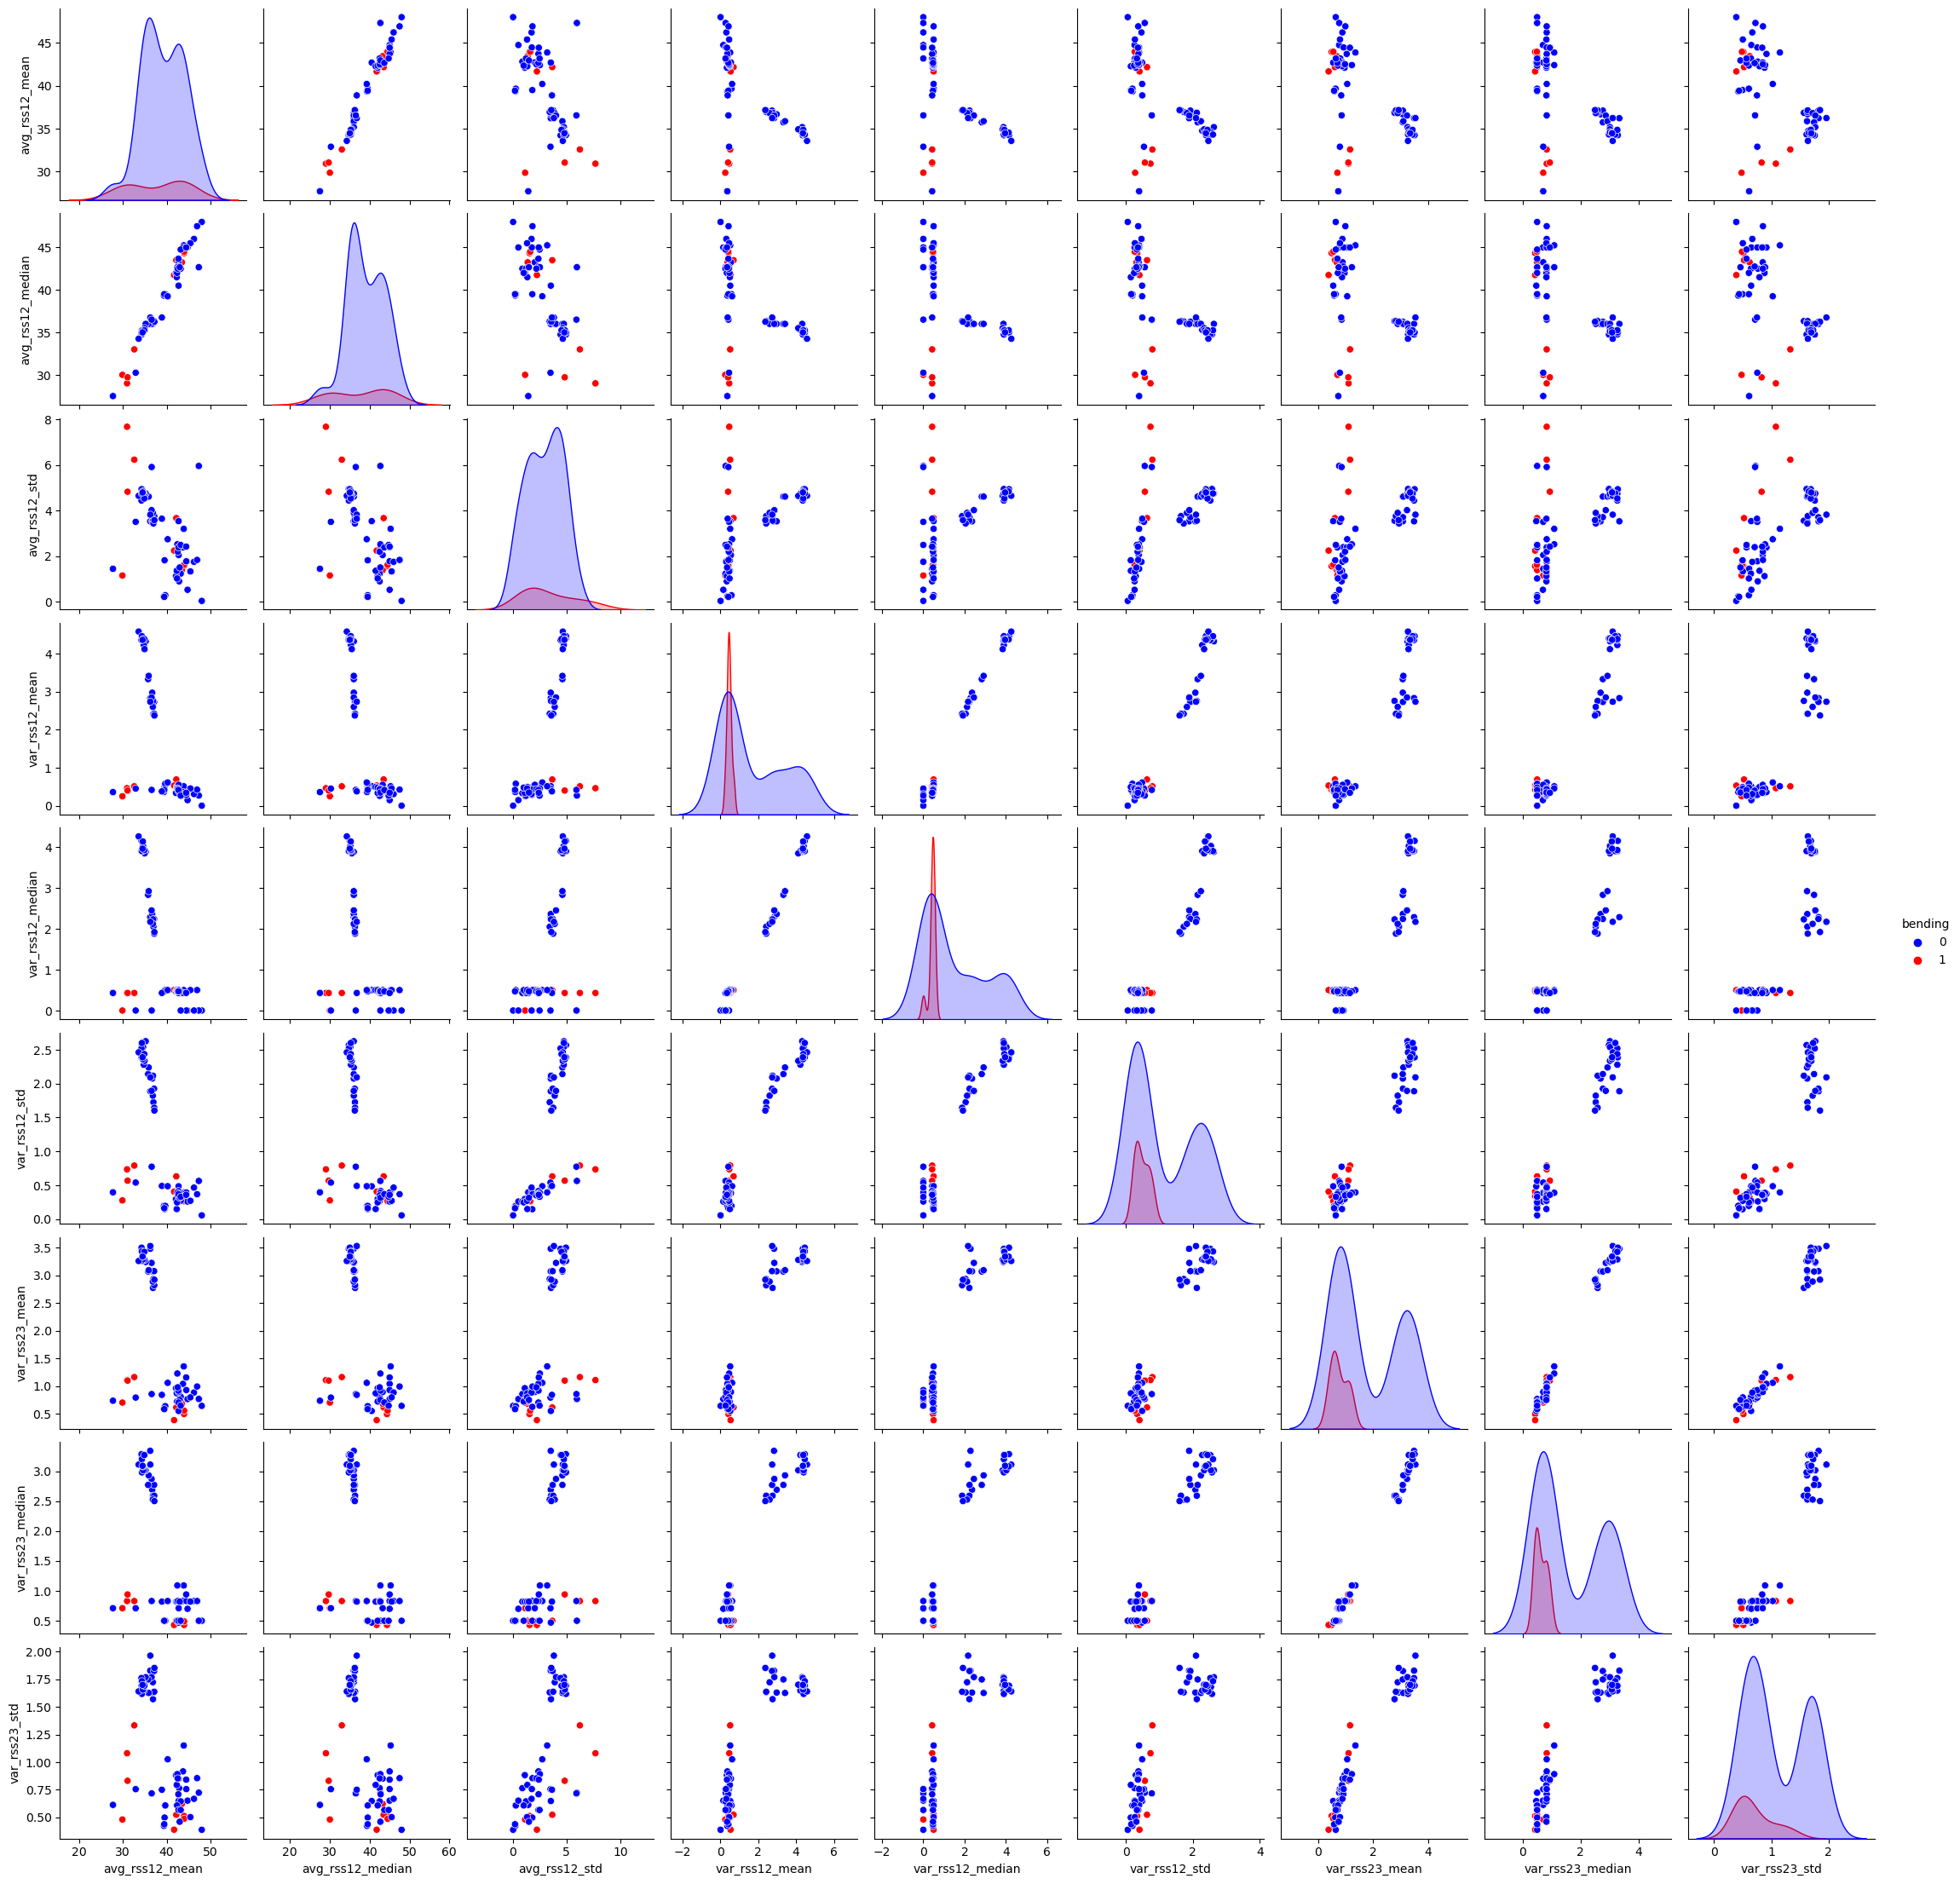

In [9]:
# lists for looping
series_names=['avg_rss12','var_rss12','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
scatter_2_a_1=[]
# finding mean meadian and std for series 1,2, and 6 from train dataset
for activity in train_datasets:
    
    for x in range(len(train_datasets[activity])):
        
        temp_list=[]
        stat=train_datasets[activity][x].describe()
        
        for series in series_names:
            for parameter in parameters:
                temp_list.append(stat[series][parameter])
                
        if activity in ['bending1','bending2']:
            temp_list.append(1)
        else:
            temp_list.append(0)
            
        scatter_2_a_1.append(temp_list)
# looping to get header names
header_list=[]
for series in series_names:
    for parameter in parameter_names:
        header_list.append(series+'_'+parameter)
header_list.append('bending')
# plotting scatter plot
scatter_2_a_1_df=pd.DataFrame(scatter_2_a_1,columns=header_list)
sns.pairplot(data=scatter_2_a_1_df, hue = 'bending', palette = {1: 'red', 0: 'blue'})

#### ii. Splitted Plots

In [10]:
# lists for looping
series_names=['avg_rss12','var_rss12','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
scatter_2_a_2=[]
l=2
# finding mean meadian and std for series 1,2, and 6 from each train dataset split into 2
for activity in train_datasets:
    
    for x in range(len(train_datasets[activity])):
        split_dfs=np.array_split(train_datasets[activity][x], l)
        
        temp_list=[]
        
        for df in split_dfs:
            stat=df.describe()
            for series in series_names:
                for parameter in parameters:
                    temp_list.append(stat[series][parameter])
        if activity in ['bending1','bending2']:
            temp_list.append(1)
        else:
            temp_list.append(0)
        scatter_2_a_2.append(temp_list)

header_list=[]
for i in range(l):
    for series in series_names:
                for parameter in parameter_names:
                    header_list.append(series+'_'+parameter+"_split_"+str(i+1))
header_list.append('bending')
scatter_2_a_2_df=pd.DataFrame(data=scatter_2_a_2,columns=header_list)

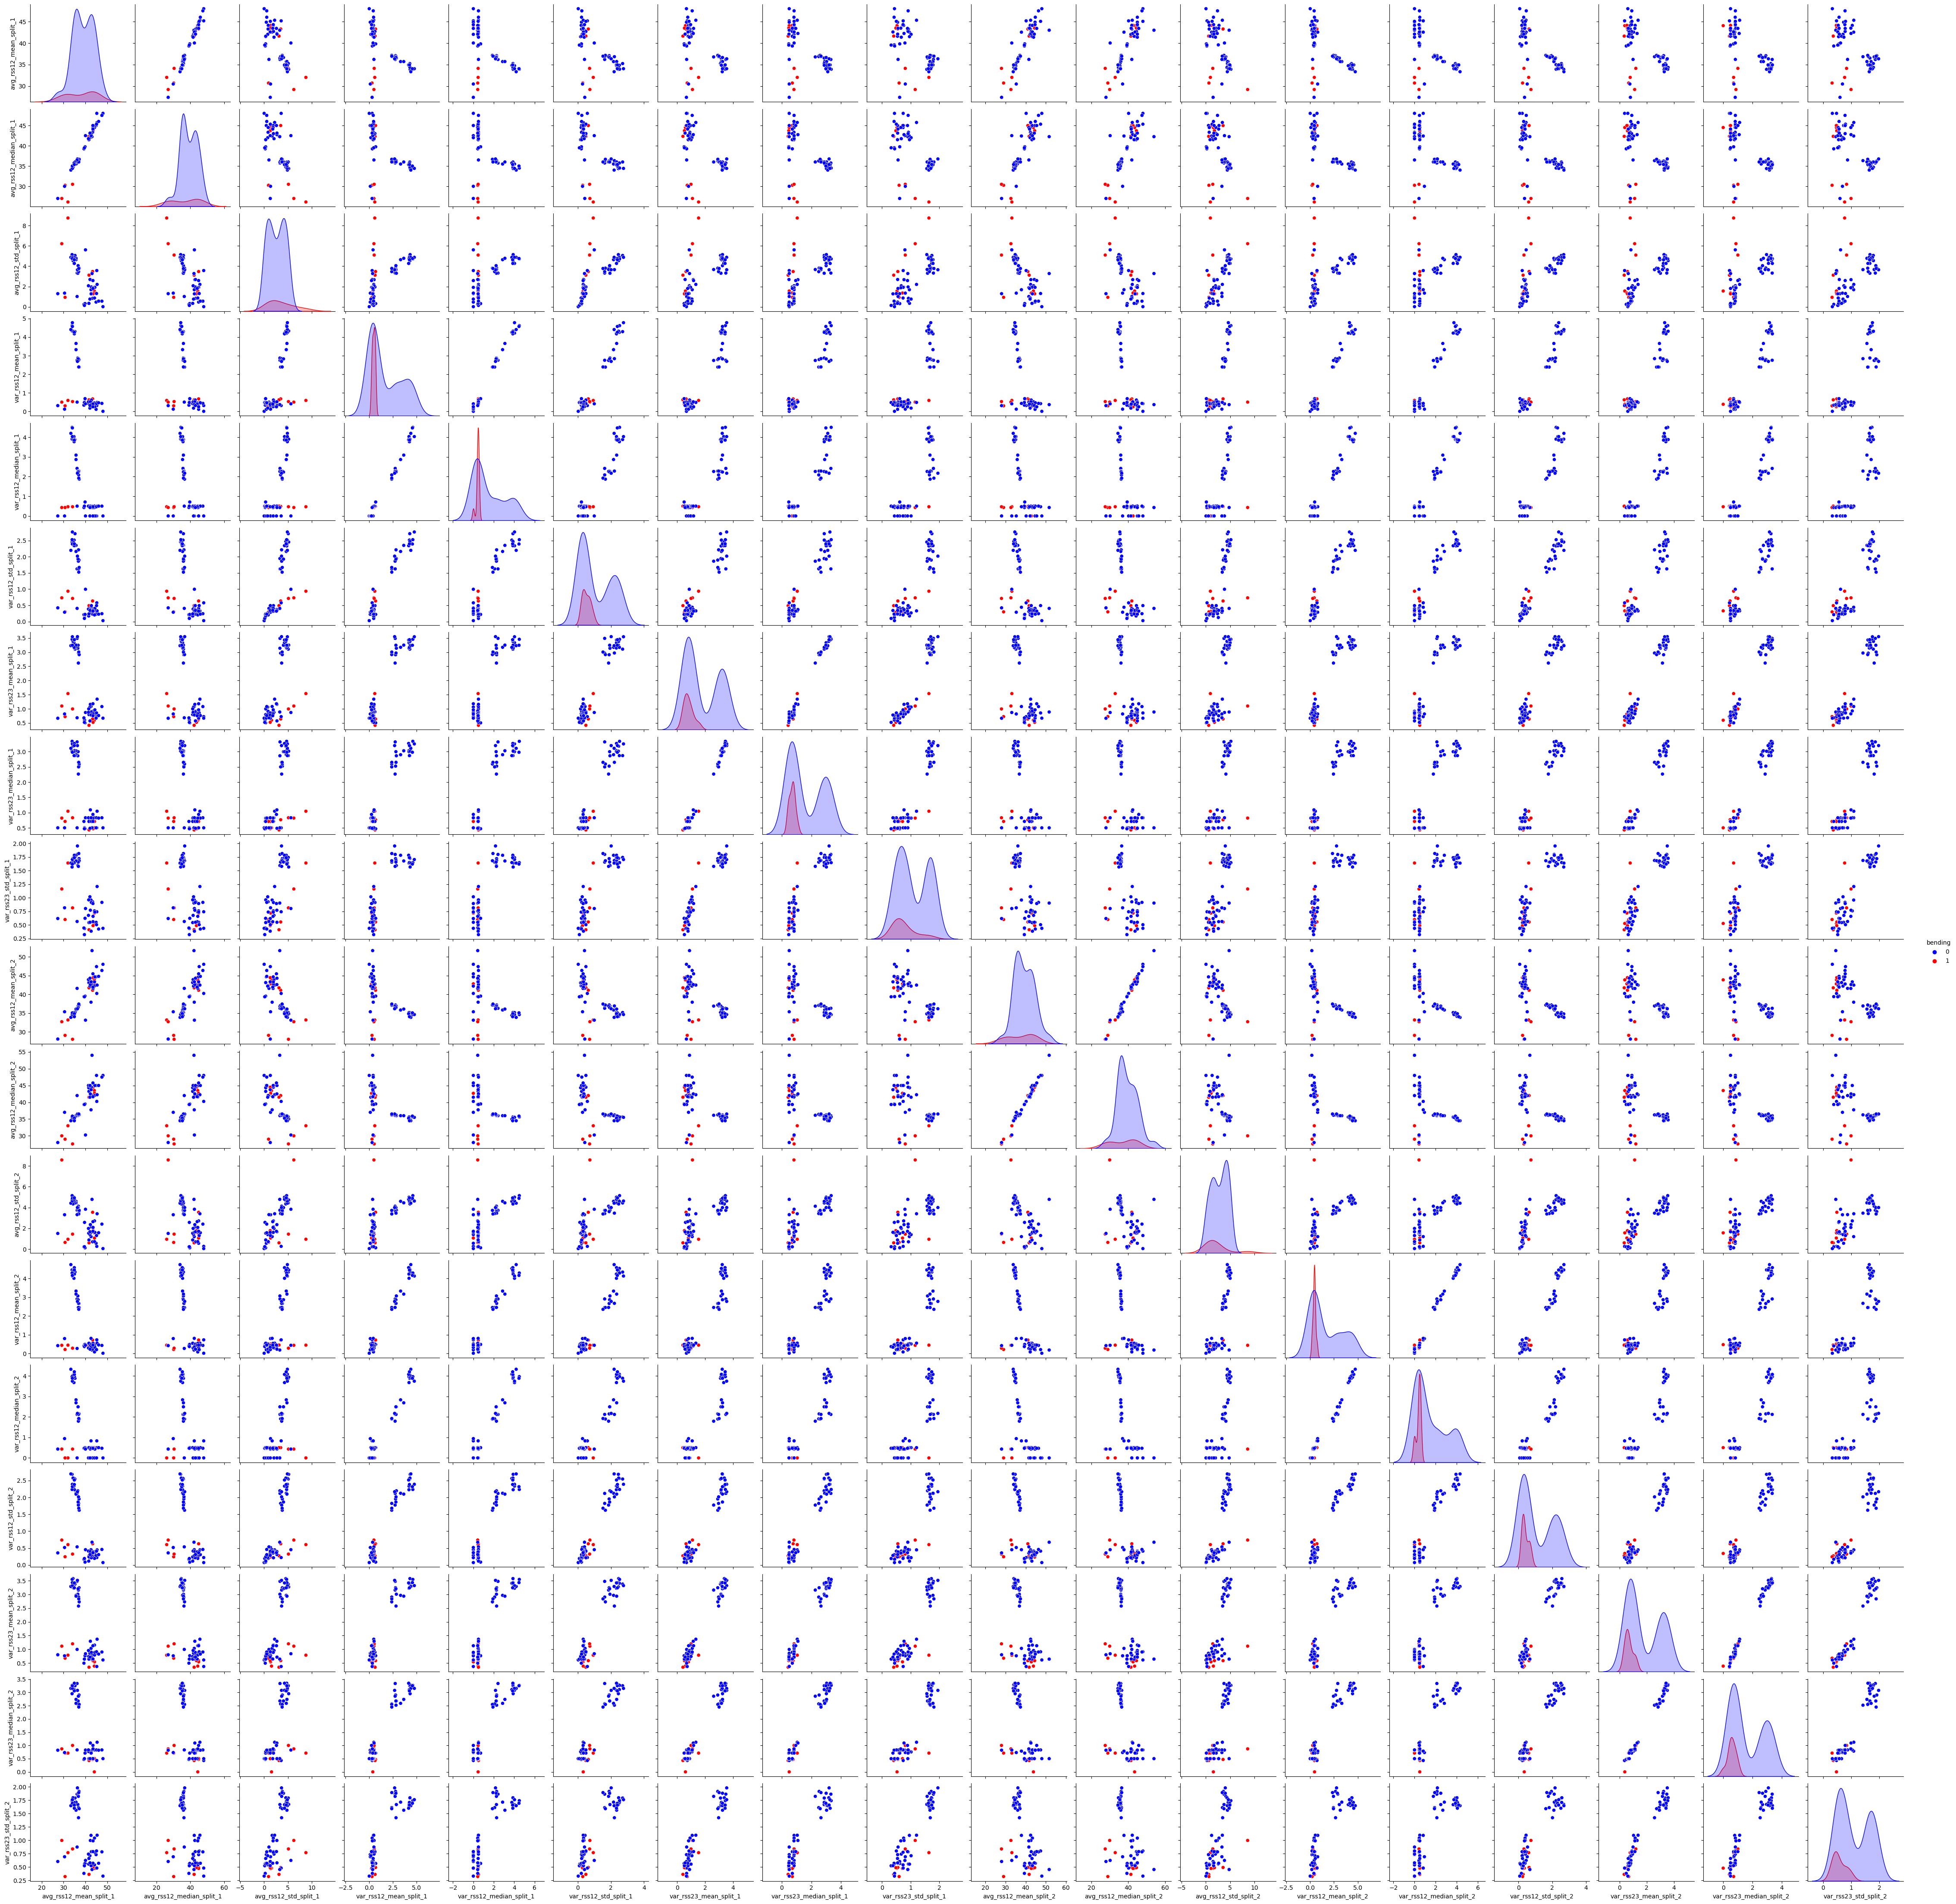

In [11]:
sns.pairplot(data=scatter_2_a_2_df, hue = 'bending', palette = {1: 'red', 0: 'blue'})

**Comparison vs 2(a)I**

Upon a brief visual inspection, I see that both scatter plots show similar pattern, hence **I believe that there isn't any significant difference between them**

#### iii. Time Series Segments

In [12]:
# fucntion to get time domain features
def get_time_domain_features(data_dict,l,series_list,parameter_list,parameter_names):
    output=[]
    for activity in data_dict:
    
        for x in range(len(data_dict[activity])):
            split_dfs=np.array_split(data_dict[activity][x], l)

            temp_list=[]

            for df in split_dfs:
                stat=df.describe()
                for series in series_list:
                    for parameter in parameter_list:
                        temp_list.append(stat[series][parameter])
            if activity in ['bending1','bending2']:
                temp_list.append(1)
            else:
                temp_list.append(0)
            output.append(temp_list)
    header_list=get_headers(series_list,parameter_names,l)
    output_df=pd.DataFrame(output,columns=header_list)
    return output_df

In [13]:
# function to get header names
def get_headers(series_list,parameter_names,l):
    output=[]
    for i in range(l):
        for series in series_list:
            for parameter in parameter_names:
                output.append(series+'_'+parameter+"_split_"+str(i+1))
    output.append('bending')
    return output

In [14]:
# variable assignment
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5
results={} 
models={}
for l in range(1,21): #looping through diff values of l
    # getting time domain features for series split into l parts
    train_td_feature_df=get_time_domain_features(train_datasets,l,series_names,parameters,parameter_names)
    train_x=train_td_feature_df.iloc[:, :-1]
    train_y=train_td_feature_df.iloc[:,-1]
    # Using RFECV to find important features
    validator = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 14)
    model = LogisticRegression(penalty = 'none', solver = 'lbfgs', max_iter = 100)
    selector = RFECV(estimator = model, cv = validator, scoring = 'accuracy')
    selector.fit(train_x, train_y)
    selected_features = train_x.columns[selector.support_].tolist()
    # fitting model to selected features
    train_x_selected_features = train_x.loc[:,selected_features]
    model.fit(train_x_selected_features,train_y)
    #storing results
    models[l]=model #storing fitted model objects in a dict
    accuracy = selector.cv_results_['mean_test_score'].max()
    error=1-accuracy
    results[l]={}
    results[l]['cv error']=error
    results[l]['cv accuracy']=accuracy
    results[l]['p']=selector.n_features_
    results[l]['selected features'] = train_x.columns[selector.support_].tolist()
    
result_dict_print={'L':results.keys() , 'P': [results[x]['p'] for x in range(1, 21)], 'cv error': [results[x]['cv error'] for x in range(1, 21)]}
pd.DataFrame(result_dict_print)

L    P  cv error
0    1    8  0.058242
1    2    6  0.057143
2    3    2  0.057143
3    4    3  0.042857
4    5    4  0.042857
5    6    2  0.028571
6    7    4  0.042857
7    8   75  0.043956
8    9    7  0.028571
9   10    1  0.042857
10  11   12  0.014286
11  12   11  0.014286
12  13   12  0.028571
13  14   23  0.028571
14  15  201  0.028571
15  16   20  0.014286
16  17    7  0.042857
17  18    3  0.042857
18  19    1  0.028571
19  20   37  0.014286

In [15]:
min_error=float('inf')
min_l=None
for x in results:
    if min_error>results[x]['cv error']:
        min_error=results[x]['cv error']
        min_l=x

print(f"The (l,p) with minimum error is \n \n l: {min_l} \n p: {results[min_l]['p']} \n train error: {round(results[min_l]['cv error'],4)}")
print("\nSelected Features are: \n")
print('\n'.join(results[min_l]['selected features']))
# Note: changing random state of the stratified K fold gives us different results

The (l,p) with minimum error is 
 
 l: 11 
 p: 12 
 train error: 0.0143

Selected Features are: 

avg_rss23_mean_split_1
avg_rss23_median_split_1
avg_rss23_mean_split_2
avg_rss23_median_split_2
avg_rss23_mean_split_4
avg_rss23_median_split_4
avg_rss12_mean_split_7
avg_rss12_median_split_7
avg_rss12_mean_split_8
avg_rss12_mean_split_9
avg_rss13_mean_split_10
avg_rss13_median_split_10


### Finding

**The right way of performing cross validation is to do it along with recursive feature elimination**. i.e) we need to provide info about what predictors are available to be used to train model before cross validation

Meanwhile, the wrong way of performing cross validation is when we select features using all of our dataset i.e) when it is done independently of cross validation method

#### iv. Confusion Matrix

In [16]:
#variable assignment
l=min_l
pruned_feature_list=results[min_l]['selected features']
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5
# getting time domain features for train dataset
train_td_feature_df=get_time_domain_features(train_datasets,l,series_names,parameters,parameter_names)
train_x=train_td_feature_df.iloc[:, :-1]
train_y=train_td_feature_df.iloc[:,-1]
train_x_selected_features = train_x.loc[:, pruned_feature_list]
# using the classifier on train dataset
pred_y=models[min_l].predict(train_x_selected_features)
prob_y=models[min_l].predict_proba(train_x_selected_features)[:, 1]
#confusion matrix
conf_matrix = confusion_matrix(train_y, pred_y)
print('Confusion Matrix is: \n',conf_matrix,'\n')
#error rate
tn, fp, fn, tp = conf_matrix.ravel()
train_accuracy = (tp + tn) / (tp + tn + fp + fn)
train_error_rate = 1 - train_accuracy
print('Error on training data is:',train_error_rate,'\n')
print('Accuracy on training data is:',train_accuracy,'\n')
#roc auc
fpr, tpr, thresholds = roc_curve(train_y, prob_y)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
# beta coefs and intercept
beta_coefficients =models[min_l].coef_[0]
intercept = models[min_l].intercept_[0]
print("Intercept:", intercept)
print("Coefficients (Beta_i's):", beta_coefficients)


Confusion Matrix is: 
 [[60  0]
 [ 0  9]] 

Error on training data is: 0.0 

Accuracy on training data is: 1.0 

AUC: 1.0
Intercept: -0.04407296953245371
Coefficients (Beta_i's): [ 1.49312818  1.44427182  1.87075124  1.81150775  1.04451969  0.96451708
 -1.03366787 -0.89108936 -1.03539385 -1.01691871 -1.01573594 -0.88253473]


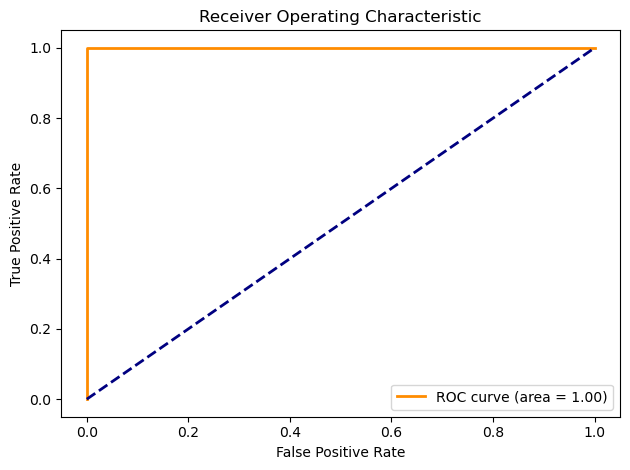

In [17]:
# plotting roc 
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### P value analysis using stats models sm.Logit

In [18]:
model_final = sm.Logit(train_y.to_numpy(dtype = float), train_x_selected_features)
summary = model_final.fit(method = 'bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 32
         Gradient evaluations: 32
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       57
Method:                           MLE   Df Model:                           11
Date:                Fri, 01 Mar 2024   Pseudo R-squ.:                   1.000
Time:                        00:44:30   Log-Likelihood:            -1.2126e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.496e-07
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
avg_rss2

#### v. Test Classifier

test confusion matrix is:
 [[15  0]
 [ 1  3]] 

test accuracy is: 0.9473684210526315 

test error is: 0.052631578947368474 



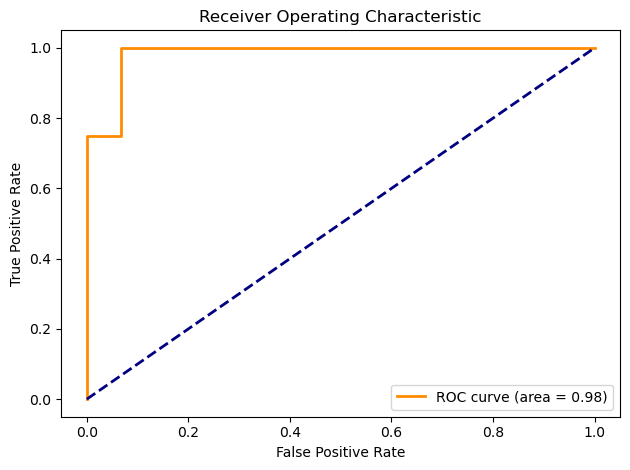

test confusion matrix is:
 [[15  0]
 [ 1  3]] 

test accuracy is: 0.9473684210526315 

test error is: 0.052631578947368474 



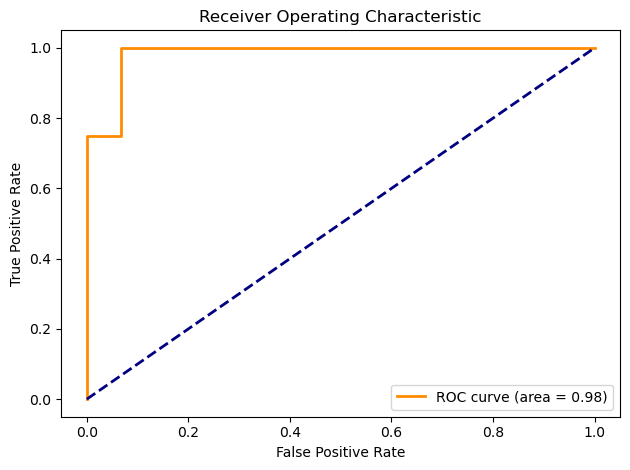

In [19]:
# assigning variables
l=min_l
pruned_feature_list=results[min_l]['selected features']
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5

# getting time domain features for l=11 and test dataset
test_td_feature_df=get_time_domain_features(test_datasets,l,series_names,parameters,parameter_names)
test_x=test_td_feature_df.iloc[:, :-1]
test_y=test_td_feature_df.iloc[:,-1]
test_x_selected_features = test_x.loc[:, pruned_feature_list]

#using test dataset on the same classifier
y_prob_test =models[min_l].predict_proba(test_x_selected_features)[:, 1]
y_pred_test =models[min_l].predict(test_x_selected_features)

# confusion matrix
cm = confusion_matrix(test_y, y_pred_test)
tn, fp, fn, tp = cm.ravel()
test_accuracy = (tp + tn) / (tp + tn + fp + fn)
test_error_rate = 1 - test_accuracy

print("test confusion matrix is:\n",cm,"\n")
print("test accuracy is:",test_accuracy,"\n")
print("test error is:",test_error_rate,"\n")

# plotting roc auc
fpr, tpr, thresholds = roc_curve(test_y, y_prob_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()# assigning variables
l=min_l
pruned_feature_list=results[min_l]['selected features']
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5

# getting time domain features for l=11 and test dataset
test_td_feature_df=get_time_domain_features(test_datasets,l,series_names,parameters,parameter_names)
test_x=test_td_feature_df.iloc[:, :-1]
test_y=test_td_feature_df.iloc[:,-1]
test_x_selected_features = test_x.loc[:, pruned_feature_list]

#using test dataset on the same classifier
y_prob_test =models[min_l].predict_proba(test_x_selected_features)[:, 1]
y_pred_test =models[min_l].predict(test_x_selected_features)

# confusion matrix
cm = confusion_matrix(test_y, y_pred_test)
tn, fp, fn, tp = cm.ravel()
test_accuracy = (tp + tn) / (tp + tn + fp + fn)
test_error_rate = 1 - test_accuracy

print("test confusion matrix is:\n",cm,"\n")
print("test accuracy is:",test_accuracy,"\n")
print("test error is:",test_error_rate,"\n")

# plotting roc auc
fpr, tpr, thresholds = roc_curve(test_y, y_prob_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### Cross validation accuracy vs Test accuracy

In [21]:
cv_accuracy=results[min_l]['cv accuracy'] # cv accuracy for l,p of 11,12

if test_accuracy>cv_accuracy:
    print(f"\nCV accuracy of {round(cv_accuracy,3)} is lower than test accuracy of {round(test_accuracy,3)}")
else:
    print(f"\nCV accuracy of {round(cv_accuracy,3)} is higher than test accuracy of {round(test_accuracy,3)}")


CV accuracy of 0.986 is higher than test accuracy of 0.947


#### vi. Separation

<font size=4>**Yes, as evident from p value analysis by stats model (2 (a) IV), the classes are well seperable and cause instability in calculating logistic regression parameters.** The maximum likelyhood estimator doesn't exit here

#### vii. Imbalance

<font size=4>**Yes, from the confusion matrices obtained while training and testing, the proportion of postive cases (bending) is low i.e) imbalanced.** Training dataset (9/69)=13%, Testing =(4/19)=21%

In [22]:
results_balanced={} 
models_balanced={}
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5
for l in range(1,21):
    # getting time domain faeatures for series split into l parts
    train_td_feature_df=get_time_domain_features(train_datasets,l,series_names,parameters,parameter_names)
    train_y=train_td_feature_df.iloc[:,-1]
    # doing case - control sampling (oversampling)
    minority_indices = np.where(train_y == 1)[0]
    majority_indices = np.where(train_y == 0)[0]
    minority_class_df=train_td_feature_df.iloc[minority_indices,:]
    minority_class_df=resample(minority_class_df, replace = True, random_state = 60, n_samples = len(majority_indices))
    majority_class_df=train_td_feature_df.iloc[majority_indices,:]
    balanced_training_df=pd.concat([minority_class_df,majority_class_df])
    train_x_balanced=balanced_training_df.iloc[:, :-1]
    train_y_balanced=balanced_training_df.iloc[:,-1]
    # Using RFECV to find important features
    validator = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 14)
    model = LogisticRegression(penalty = 'none', solver = 'lbfgs', max_iter = 100)
    selector = RFECV(estimator = model, cv = validator, scoring = 'accuracy')
    selector.fit(train_x_balanced, train_y_balanced)
    selected_features = train_x_balanced.columns[selector.support_].tolist()
    # fitting model to selected features
    train_x_selected_features_balanced = train_x_balanced.loc[:,selected_features]
    model.fit(train_x_selected_features_balanced,train_y_balanced)
    #storing results
    models_balanced[l]=model #storing fitted model objects in a dict
    accuracy = selector.cv_results_['mean_test_score'].max()
    error=1-accuracy
    results_balanced[l]={}
    results_balanced[l]['cv error']=error
    results_balanced[l]['cv accuracy']=accuracy
    results_balanced[l]['p']=selector.n_features_
    results_balanced[l]['selected features'] = selected_features
    
result_dict_print_balanced={'L':results_balanced.keys() , 'P': [results_balanced[x]['p'] for x in range(1, 21)], 'cv error': [results_balanced[x]['cv error'] for x in range(1, 21)]}
pd.DataFrame(result_dict_print_balanced)

L   P  cv error
0    1   9  0.016667
1    2   6  0.025000
2    3   3  0.016667
3    4   4  0.016667
4    5   4  0.016667
5    6   6  0.008333
6    7   8  0.016667
7    8   4  0.008333
8    9   5  0.008333
9   10   6  0.008333
10  11  13  0.000000
11  12  12  0.008333
12  13   8  0.000000
13  14   3  0.008333
14  15   7  0.008333
15  16  12  0.000000
16  17   4  0.008333
17  18   4  0.000000
18  19   9  0.000000
19  20   9  0.000000

In [23]:
min_error_balanced=float('inf')
min_l_balanced=None
for x in results_balanced:
    if min_error_balanced>results_balanced[x]['cv error']:
        min_error_balanced=results_balanced[x]['cv error']
        min_l_balanced=x

print(f"The (l,p) with minimum error is \n \n l: {min_l_balanced} \n p: {results_balanced[min_l_balanced]['p']} \n train error: {round(results_balanced[min_l_balanced]['cv error'],4)}")
print("\nSelected Features are: \n")
print('\n'.join(results[min_l]['selected features']))
# Note: changing random state of the stratified K fold gives us different results

The (l,p) with minimum error is 
 
 l: 11 
 p: 13 
 train error: 0.0

Selected Features are: 

avg_rss23_mean_split_1
avg_rss23_median_split_1
avg_rss23_mean_split_2
avg_rss23_median_split_2
avg_rss23_mean_split_4
avg_rss23_median_split_4
avg_rss12_mean_split_7
avg_rss12_median_split_7
avg_rss12_mean_split_8
avg_rss12_mean_split_9
avg_rss13_mean_split_10
avg_rss13_median_split_10


### Train Accuracy ROC AUC

In [24]:
#variable assignment
l=min_l_balanced
pruned_feature_list=results_balanced[min_l_balanced]['selected features']
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5
# getting time domain features for train dataset
train_td_feature_df=get_time_domain_features(train_datasets,l,series_names,parameters,parameter_names)
train_x=train_td_feature_df.iloc[:, :-1]
train_y=train_td_feature_df.iloc[:,-1]
train_x_selected_features = train_x.loc[:, pruned_feature_list]
# using the classifier on train dataset
pred_y=models_balanced[min_l_balanced].predict(train_x_selected_features)
prob_y=models_balanced[min_l_balanced].predict_proba(train_x_selected_features)[:, 1]
#confusion matrix
conf_matrix = confusion_matrix(train_y, pred_y)
print('Confusion Matrix is: \n',conf_matrix,'\n')
#error rate
tn, fp, fn, tp = conf_matrix.ravel()
train_accuracy = (tp + tn) / (tp + tn + fp + fn)
train_error_rate = 1 - train_accuracy
print('Error on training data is:',train_error_rate,'\n')
print('Accuracy on training data is:',train_accuracy,'\n')
#roc auc
fpr, tpr, thresholds = roc_curve(train_y, prob_y)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
# beta coefs and intercept
beta_coefficients =models_balanced[min_l_balanced].coef_[0]
intercept = models_balanced[min_l_balanced].intercept_[0]
print("Intercept:", intercept)
print("Coefficients (Beta_i's):", beta_coefficients)

Confusion Matrix is: 
 [[60  0]
 [ 0  9]] 

Error on training data is: 0.0 

Accuracy on training data is: 1.0 

AUC: 1.0
Intercept: -0.04144144786804944
Coefficients (Beta_i's): [-0.89328389  1.25049358  1.07654062  0.64999743 -0.77481335 -1.07906095
 -0.75003732 -0.80927143 -0.79447898 -0.86804387 -0.87830684  1.03861294
  0.97303283]


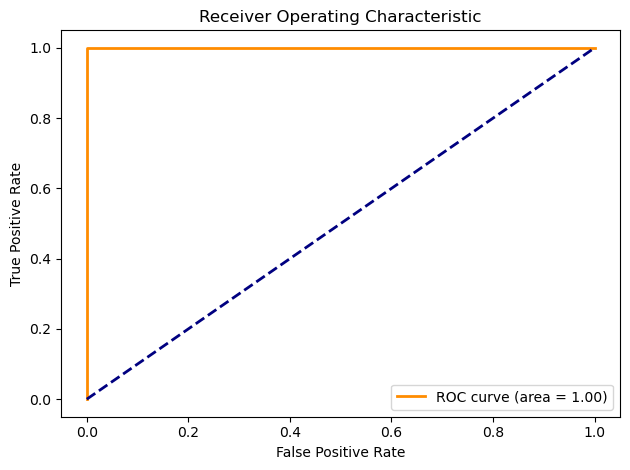

In [25]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### Testing ROC AUC

In [26]:
# getting time domain features for test dataset
test_td_feature_df=get_time_domain_features(test_datasets,l,series_names,parameters,parameter_names)
test_x=test_td_feature_df.iloc[:, :-1]
test_y=test_td_feature_df.iloc[:,-1]
test_x_selected_features = test_x.loc[:, pruned_feature_list]

y_prob_test =models_balanced[min_l_balanced].predict_proba(test_x_selected_features)[:, 1]
y_pred_test =models_balanced[min_l_balanced].predict(test_x_selected_features)
cm = confusion_matrix(test_y, y_pred_test)

test confusion matrix is:
 [[15  0]
 [ 1  3]] 

test accuracy is: 0.9473684210526315 

test error is: 0.052631578947368474 



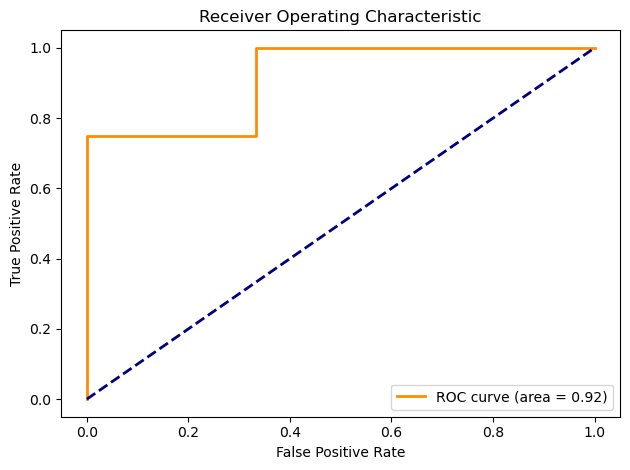

In [27]:
# calculating error and accuracy on test
tn, fp, fn, tp = cm.ravel()
test_accuracy = (tp + tn) / (tp + tn + fp + fn)
test_error_rate = 1 - test_accuracy
# printing results and plotting roc
print("test confusion matrix is:\n",cm,"\n")
print("test accuracy is:",test_accuracy,"\n")
print("test error is:",test_error_rate,"\n")

fpr, tpr, thresholds = roc_curve(test_y, y_prob_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [28]:
# Variable assignment 
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5
results_l1={} 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
# looping through different values of l(dataset split)
for l in range(1,21):
    train_td_feature_df=get_time_domain_features(train_datasets,l,series_names,parameters,parameter_names)
    train_x=train_td_feature_df.iloc[:, :-1]
    train_y=train_td_feature_df.iloc[:,-1]
    # initializing stratified K folds for cross validation
    validator = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 14)
    # grid search to tune C i.e) budget
    results_l1[l]={}
    grid_search = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear',max_iter = 100,random_state=11), param_grid, cv=validator, scoring='accuracy')
    grid_search.fit(train_x,train_y)
    # best C and estimator
    best_C = grid_search.best_params_['C']
    best_estimator = grid_search.best_estimator_
    results_l1[l]['Best C']=best_C
    results_l1[l]['Best model']=best_estimator
    # cross validation score for best estimator
    cross_val_acc = np.mean(cross_val_score(best_estimator, train_x, train_y, cv=validator))
    results_l1[l]['cv accuracy']=cross_val_acc
    results_l1[l]['cv error']=1-cross_val_acc
    # getting non zero coefficients and corresponding predictors
    selected_pred_indices=np.where(best_estimator.coef_[0]!=0)
    selected_predictors= [train_x.columns[i] for i in selected_pred_indices]
    beta_values=[best_estimator.coef_[0][i] for i in selected_pred_indices]
    results_l1[l]['selected predictors']=selected_predictors
    results_l1[l]['Beta values']=beta_values

In [30]:
#printing results
result_dict_print_l1={'L':results_l1.keys() , 'Best C': [results_l1[x]['Best C'] for x in range(1, 21)], 'non zero predictors':[len(results_l1[x]['Beta values'][0]) for x in range(1, 21)], 'cv error': [results_l1[x]['cv error'] for x in range(1, 21)], 'cv accuracy':[results_l1[x]['cv accuracy'] for x in range(1, 21)]}
pd.DataFrame(result_dict_print_l1)

L  Best C  non zero predictors  cv error  cv accuracy
0    1     1.0                    5  0.058242     0.941758
1    2     0.1                    3  0.057143     0.942857
2    3     1.0                    8  0.042857     0.957143
3    4     0.1                    3  0.042857     0.957143
4    5     1.0                    6  0.042857     0.957143
5    6     0.1                    3  0.042857     0.957143
6    7    10.0                   20  0.042857     0.957143
7    8    10.0                   29  0.057143     0.942857
8    9    10.0                   19  0.042857     0.957143
9   10     0.1                    5  0.042857     0.957143
10  11     0.1                    3  0.028571     0.971429
11  12     0.1                    5  0.042857     0.957143
12  13     0.1                    3  0.042857     0.957143
13  14     1.0                   12  0.057143     0.942857
14  15     1.0                   19  0.042857     0.957143
15  16     1.0                   21  0.042857     0.957143
16  17     0.1                    8  0.042857     0.957143
17  18     0.1                    3  0.042857     0.957143
18  19     0.1                    6  0.042857     0.957143
19  20     0.1                    6  0.042857     0.957143

In [31]:
# finding pair of l,C with minimum error
min_l1_error=float('inf')
min_l1_l=None
for l in results_l1:
    if min_l1_error>results_l1[l]['cv error']:
        min_l1_error=results_l1[l]['cv error']
        min_l1_l=l
print(f" L , C(budget) with minimum cv error is: \n L={min_l1_l}, C={results_l1[min_l1_l]['Best C']}, CV error={round(results_l1[min_l1_l]['cv error'],4)}")
print("\nPredictors with non zero coefficients are:")
print_dict={'predictor':results_l1[min_l1_l]['selected predictors'][0],'Beta Values':results_l1[min_l1_l]['Beta values'][0]}
pd.DataFrame(print_dict)

 L , C(budget) with minimum cv error is: 
 L=11, C=0.1, CV error=0.0286

Predictors with non zero coefficients are:


predictor  Beta Values
0    avg_rss23_mean_split_2     0.027003
1  avg_rss23_median_split_2     0.372381
2  avg_rss12_median_split_7    -0.253499

Confusion Matrix is: 
 [[60  0]
 [ 1  8]] 

Error on training data is: 0.0145 

Accuracy on training data is: 0.9855 

AUC: 1.0


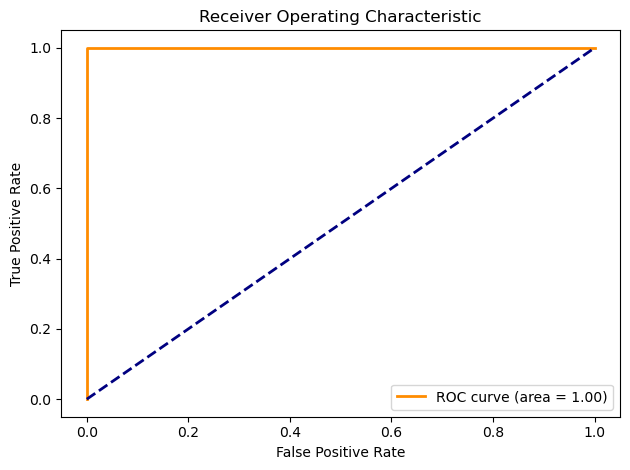

In [33]:
# Confusion matrix and ROC for best l, C

#Variable assignment
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5
#getting time domain features for l=11
l=11
train_td_feature_df=get_time_domain_features(train_datasets,l,series_names,parameters,parameter_names)
train_x=train_td_feature_df.iloc[:, :-1]
train_y=train_td_feature_df.iloc[:,-1]
#confusion matrix and ROC
pred_y_l1=results_l1[min_l1_l]['Best model'].predict(train_x)
prob_y_l1=results_l1[min_l1_l]['Best model'].predict_proba(train_x)[:, 1]
conf_matrix = confusion_matrix(train_y, pred_y_l1)
print('Confusion Matrix is: \n',conf_matrix,'\n')
#error rate
tn, fp, fn, tp = conf_matrix.ravel()
train_accuracy = (tp + tn) / (tp + tn + fp + fn)
train_error_rate = 1 - train_accuracy
print('Error on training data is:',round(train_error_rate,4),'\n')
print('Accuracy on training data is:',round(train_accuracy,4),'\n')
#roc auc
fpr, tpr, thresholds = roc_curve(train_y, prob_y_l1)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

# plot roc auc
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

#### ii. Comparison

### Gettting test dataset error/accuracy for l1 penalized regression

In [34]:
train_td_feature_df=get_time_domain_features(test_datasets,l,series_names,parameters,parameter_names)
test_x=train_td_feature_df.iloc[:, :-1]
test_y=train_td_feature_df.iloc[:,-1]
#confusion matrix and ROC
pred_y_l1_test=results_l1[min_l1_l]['Best model'].predict(test_x)
prob_y_l1_test=results_l1[min_l1_l]['Best model'].predict_proba(test_x)[:, 1]
conf_matrix = confusion_matrix(test_y, pred_y_l1_test)
print('Confusion Matrix is: \n',conf_matrix,'\n')
#error rate
tn, fp, fn, tp = conf_matrix.ravel()
test_accuracy_l1 = (tp + tn) / (tp + tn + fp + fn)
test_error_rate_l1 = 1 - test_accuracy_l1
print('Error on test data is:',round(test_error_rate_l1,4),'\n')
print('Accuracy on test data is:',round(test_accuracy_l1,4),'\n')
#roc auc
fpr, tpr, thresholds = roc_curve(test_y, prob_y_l1_test)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

Confusion Matrix is: 
 [[15  0]
 [ 1  3]] 

Error on test data is: 0.0526 

Accuracy on test data is: 0.9474 

AUC: 1.0


All 3 models below have the same confusion matrix on the test dataset, 
i.e)

[[15 0]
[1 3]] 

and hence have the same efficacy

1. Logistic regression with Recursive feature elimination with Cross Validtion
2. Logistic regresion with RFECV with a balanced training dataset
3. L1 penalized logistic regression

**L1 penalized is the easier one to implement** though as feature selection is an inherent capability of the model

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [35]:
# fucntion to get time domain features for multi class classification
def get_time_domain_features_multi_class(data_dict,l,series_list,parameter_list,parameter_names):
    output=[]
    for activity in data_dict:
    
        for x in range(len(data_dict[activity])):
            split_dfs=np.array_split(data_dict[activity][x], l)

            temp_list=[]

            for df in split_dfs:
                stat=df.describe()
                for series in series_list:
                    for parameter in parameter_list:
                        temp_list.append(stat[series][parameter])
            temp_list.append(activity)
            output.append(temp_list)
    header_list=get_headers_multi_class(series_list,parameter_names,l)
    output_df=pd.DataFrame(output,columns=header_list)
    return output_df

In [36]:
# function to get header names for multi class classification
def get_headers_multi_class(series_list,parameter_names,l):
    output=[]
    for i in range(l):
        for series in series_list:
            for parameter in parameter_names:
                output.append(series+'_'+parameter+"_split_"+str(i+1))
    output.append('activity')
    return output

In [37]:
# Variable assignment 
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5
results_l1_multi={} 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
# looping through different values of l(dataset split)
for l in range(1,21):
    train_td_feature_df=get_time_domain_features_multi_class(train_datasets,l,series_names,parameters,parameter_names)
    train_x=train_td_feature_df.iloc[:, :-1]
    train_y=train_td_feature_df.iloc[:,-1]
    # initializing stratified K folds for cross validation
    validator = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 12)
    # grid search to tune C i.e) budget
    results_l1_multi[l]={}
    grid_search = GridSearchCV(LogisticRegression(penalty='l1', solver='saga',multi_class='multinomial',max_iter = 1000,random_state=15), param_grid, cv=validator, scoring='accuracy')
    grid_search.fit(train_x,train_y)
    # best C and estimator
    best_C = grid_search.best_params_['C']
    best_estimator = grid_search.best_estimator_
    results_l1_multi[l]['Best C']=best_C
    results_l1_multi[l]['Best model']=best_estimator
    # cross validation score for best estimator
    cross_val_acc = np.mean(cross_val_score(best_estimator, train_x, train_y, cv=validator))
    results_l1_multi[l]['cv accuracy']=cross_val_acc
    results_l1_multi[l]['cv error']=1-cross_val_acc
    # getting non zero coefficients and corresponding predictors
    selected_pred_indices=np.where(best_estimator.coef_[0]!=0)
    selected_predictors= [train_x.columns[i] for i in selected_pred_indices]
    beta_values=[best_estimator.coef_[0][i] for i in selected_pred_indices]
    results_l1_multi[l]['selected predictors']=selected_predictors
    results_l1_multi[l]['Beta values']=beta_values

In [38]:
#printing results
result_dict_print_l1_multi={'L':results_l1_multi.keys() , 'Best C': [results_l1_multi[x]['Best C'] for x in range(1, 21)], 'non zero predictors':[len(results_l1_multi[x]['Beta values'][0]) for x in range(1, 21)], 'cv error': [results_l1_multi[x]['cv error'] for x in range(1, 21)], 'cv accuracy':[results_l1_multi[x]['cv accuracy'] for x in range(1, 21)]}
pd.DataFrame(result_dict_print_l1_multi)

L  Best C  non zero predictors  cv error  cv accuracy
0    1       1                    8  0.114286     0.885714
1    2      10                   36  0.159341     0.840659
2    3       1                   26  0.174725     0.825275
3    4      10                   71  0.203297     0.796703
4    5      10                   88  0.203297     0.796703
5    6      10                  107  0.231868     0.768132
6    7      10                  124  0.217582     0.782418
7    8      10                  139  0.247253     0.752747
8    9      10                  159  0.232967     0.767033
9   10      10                  179  0.218681     0.781319
10  11      10                  198  0.204396     0.795604
11  12      10                  211  0.234066     0.765934
12  13      10                  229  0.247253     0.752747
13  14      10                  248  0.234066     0.765934
14  15      10                  266  0.219780     0.780220
15  16     100                  288  0.232967     0.767033
16  17      10                  302  0.232967     0.767033
17  18       1                  132  0.248352     0.751648
18  19       1                  137  0.262637     0.737363
19  20     100                  360  0.232967     0.767033

In [40]:
# finding pair of l,C with minimum error
min_l1_error_multi=float('inf')
min_l1_l_multi=None
for l in results_l1_multi:
    if min_l1_error_multi>results_l1_multi[l]['cv error']:
        min_l1_error_multi=results_l1_multi[l]['cv error']
        min_l1_l_multi=l
print(f" L , C(budget) with minimum cv error is: \n L={min_l1_l_multi}, C={results_l1_multi[min_l1_l_multi]['Best C']}, CV error={round(results_l1_multi[min_l1_l_multi]['cv error'],4)}")
print("\nPredictors with non zero coefficients are:")
print_dict={'predictor':results_l1_multi[min_l1_l_multi]['selected predictors'][0],'Beta Values':results_l1_multi[min_l1_l_multi]['Beta values'][0]}
pd.DataFrame(print_dict)

 L , C(budget) with minimum cv error is: 
 L=1, C=1, CV error=0.1143

Predictors with non zero coefficients are:


predictor  Beta Values
0    avg_rss12_mean_split_1    -0.132650
1     avg_rss12_std_split_1    -0.259265
2    avg_rss13_mean_split_1     0.035198
3     avg_rss13_std_split_1    -0.128742
4    avg_rss23_mean_split_1     0.288577
5  avg_rss23_median_split_1     0.245179
6    var_rss23_mean_split_1    -0.074256
7  var_rss23_median_split_1    -0.059189

### Research about confusion matrix for mutli class classification

For each class in a multi-class problem, the confusion matrix is structured as a square matrix where the rows represent the true class labels and the columns represent the predicted class labels. Each cell in the matrix represents the count of instances falling into a particular combination of true and predicted classes.

In this matrix:

<br>The diagonal elements (e.g., TP_A, TP_B, TP_C) represent correct predictions.
<br>Off-diagonal elements represent incorrect predictions.
<br>The rows represent the true classes, while the columns represent the predicted classes.

**Here's a visual representation of a confusion matrix for a multi-class classification problem with three classes (Class A, Class B, and Class C):**

In [42]:
#      Predicted Class
#           |  Class A  |  Class B  |  Class C  |
# -------------------------------------------------
#True Class |           |           |           |
#  Class A  |    TP_A   |    FP_A   |    FN_A   |
# -------------------------------------------------
#True Class |           |           |           |
#  Class B  |    FN_B   |    TP_B   |    FP_B   |
# -------------------------------------------------
#True Class |           |           |           |
#  Class C  |    FP_C   |    FN_C   |    TP_C   |
# -------------------------------------------------

### ROC AUC for train

Accuracy and ROC Curve for Training Dataset


 Confusion matrix : 
 [[ 5  0  0  0  0  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  1 11  0  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]
Training accuracy is : 0.95652
Training error rate is : 0.04348
Average ROC AUC Score: 0.99809


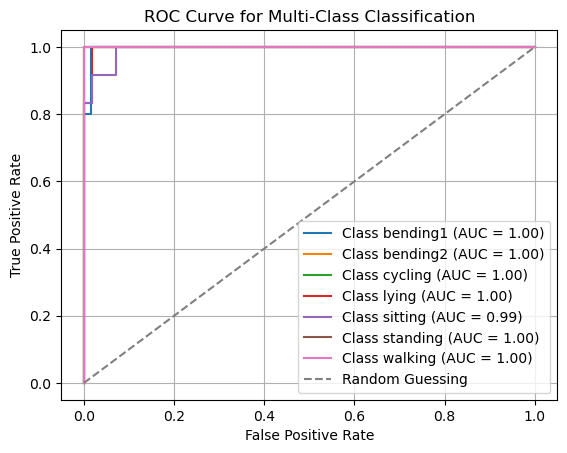

In [43]:
# finding confusion matrix, error, roc & auc for training datawset
print("Accuracy and ROC Curve for Training Dataset\n")
l=1
#getting training dataset
train_td_feature_df=get_time_domain_features_multi_class(train_datasets,l,series_names,parameters,parameter_names)
train_x=train_td_feature_df.iloc[:, :-1]
train_y=train_td_feature_df.iloc[:,-1]
#using best classifier from above to predict class
y_pred_multi = results_l1_multi[min_l1_l_multi]['Best model'].predict(train_x)
y_probs_multi = results_l1_multi[min_l1_l_multi]['Best model'].predict_proba(train_x)
cm = confusion_matrix(train_y, y_pred_multi)
print("\n Confusion matrix : \n",cm)
train_accuracy_multi = accuracy_score(train_y, y_pred_multi)
train_error_multi=1-train_accuracy_multi
print("Training accuracy is :",round(train_accuracy_multi,5))
print("Training error rate is :",round(train_error_multi,5))
roc_auc_scores = []
for index,activity in enumerate(train_datasets):
    # For each class, create a binary target vector indicating whether the class is the positive class
    true_y = np.array([1 if label == activity else 0 for label in train_y])
    # Compute the ROC AUC score for the current class
    roc_auc = roc_auc_score(true_y, y_probs_multi[:, index])
    roc_auc_scores.append(roc_auc)
    # roc curve for current class
    fpr, tpr, _ = roc_curve(true_y, y_probs_multi[:, index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {activity} (AUC = {roc_auc:.2f})')
    
# Compute the average ROC AUC score across all classes
avg_roc_auc = np.mean(roc_auc_scores)
print("Average ROC AUC Score:", round(avg_roc_auc,5))

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### ROC AUC for Test

Accuracy and ROC Curve for Test Dataset


 Confusion matrix : 
 [[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
Test accuracy is : 0.94737
Test error rate is : 0.05263
Average ROC AUC Score: 0.99702


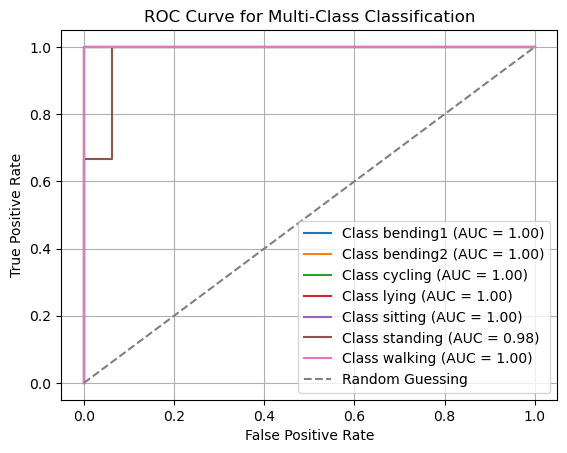

In [44]:
# finding confusion matrix, error, roc & auc for test datawset
print("Accuracy and ROC Curve for Test Dataset\n")
l=1
#getting test dataset
test_td_feature_df=get_time_domain_features_multi_class(test_datasets,l,series_names,parameters,parameter_names)
test_x=test_td_feature_df.iloc[:, :-1]
test_y=test_td_feature_df.iloc[:,-1]
#using best classifier from above to predict class
y_pred_multi = results_l1_multi[min_l1_l_multi]['Best model'].predict(test_x)
y_probs_multi = results_l1_multi[min_l1_l_multi]['Best model'].predict_proba(test_x)
cm = confusion_matrix(test_y, y_pred_multi)
print("\n Confusion matrix : \n",cm)
test_accuracy_multi = accuracy_score(test_y, y_pred_multi)
test_error_multi=1-test_accuracy_multi
print("Test accuracy is :",round(test_accuracy_multi,5))
print("Test error rate is :",round(test_error_multi,5))
roc_auc_scores = []
for index,activity in enumerate(test_datasets):
    # For each class, create a binary target vector indicating whether the class is the positive class
    true_y = np.array([1 if label == activity else 0 for label in test_y])
    # Compute the ROC AUC score for the current class
    roc_auc = roc_auc_score(true_y, y_probs_multi[:, index])
    roc_auc_scores.append(roc_auc)
    # roc curve for current class
    fpr, tpr, _ = roc_curve(true_y, y_probs_multi[:, index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {activity} (AUC = {roc_auc:.2f})')
    
# Compute the average ROC AUC score across all classes
avg_roc_auc = np.mean(roc_auc_scores)
print("Average ROC AUC Score:", round(avg_roc_auc,5))

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### ii. Naive Bayes

### Gaussian NB

In [45]:
# Variable assignment 
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5
results_Gaussian_NB={}
# looping through different values of l(dataset split)
for l in range(1,21):
    train_td_feature_df=get_time_domain_features_multi_class(train_datasets,l,series_names,parameters,parameter_names)
    train_x=train_td_feature_df.iloc[:, :-1]
    train_y=train_td_feature_df.iloc[:,-1]
    # initializing stratified K folds for cross validation
    validator = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 14)
    # fitting gaussian NB
    results_Gaussian_NB[l]={}
    model = GaussianNB()
    model.fit(train_x,train_y)
    cv_accuracy = np.mean(cross_val_score(model, train_x, train_y, cv=validator,scoring='accuracy'))
    cv_error=1-cv_accuracy
    results_Gaussian_NB[l]['cv error']=cv_error
    results_Gaussian_NB[l]['cv accuracy']=cv_accuracy
    results_Gaussian_NB[l]['model']=model

In [46]:
#printing results
result_dict_print_gaussian_NB={'L':results_Gaussian_NB.keys() , 'cv error': [results_Gaussian_NB[x]['cv error'] for x in range(1, 21)], 'cv accuracy':[results_Gaussian_NB[x]['cv accuracy'] for x in range(1, 21)]}
pd.DataFrame(result_dict_print_gaussian_NB)

L  cv error  cv accuracy
0    1  0.145055     0.854945
1    2  0.172527     0.827473
2    3  0.216484     0.783516
3    4  0.201099     0.798901
4    5  0.172527     0.827473
5    6  0.229670     0.770330
6    7  0.200000     0.800000
7    8  0.273626     0.726374
8    9  0.228571     0.771429
9   10  0.171429     0.828571
10  11  0.215385     0.784615
11  12  0.228571     0.771429
12  13  0.287912     0.712088
13  14  0.186813     0.813187
14  15  0.229670     0.770330
15  16  0.258242     0.741758
16  17  0.246154     0.753846
17  18  0.229670     0.770330
18  19  0.245055     0.754945
19  20  0.287912     0.712088

In [47]:
min_l_nb_gaussian=None
min_error_nb_gaussian=float('inf')
for l in results_Gaussian_NB:
    if min_error_nb_gaussian>results_Gaussian_NB[l]['cv error']:
        min_error_nb_gaussian=results_Gaussian_NB[l]['cv error']
        min_l_nb_gaussian=l

print('L with minimum cv error is:',min_l_nb_gaussian)
print('cv error is:',round(min_error_nb_gaussian,4))
print('cv accuracy is:',round(results_Gaussian_NB[min_l_nb_gaussian]['cv accuracy'],4))

L with minimum cv error is: 1
cv error is: 0.1451
cv accuracy is: 0.8549


#### Confusion matrix , ROC for Training Dataset

Accuracy and ROC Curve for Training Dataset


 Confusion matrix : 
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  0 10  1  0]
 [ 0  0  0  0  1 11  0]
 [ 0  0  0  0  0  0 12]]
Train accuracy is : 0.95652
Train error rate is : 0.04348
Average ROC AUC Score: 0.99841


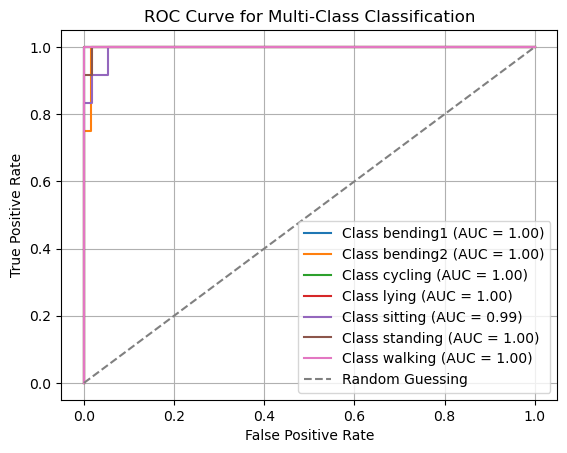

In [48]:
# finding confusion matrix, error, roc & auc for training datawset
print("Accuracy and ROC Curve for Training Dataset\n")
l=1
#getting training dataset
train_td_feature_df=get_time_domain_features_multi_class(train_datasets,l,series_names,parameters,parameter_names)
train_x=train_td_feature_df.iloc[:, :-1]
train_y=train_td_feature_df.iloc[:,-1]
#using best classifier from above to predict class
y_pred_gnb = results_Gaussian_NB[min_l_nb_gaussian]['model'].predict(train_x)
y_probs_gnb = results_Gaussian_NB[min_l_nb_gaussian]['model'].predict_proba(train_x)
cm = confusion_matrix(train_y, y_pred_gnb)
print("\n Confusion matrix : \n",cm)
train_accuracy_gnb = accuracy_score(train_y, y_pred_gnb)
train_error_gnb=1-train_accuracy_gnb
print("Train accuracy is :",round(train_accuracy_gnb,5))
print("Train error rate is :",round(train_error_gnb,5))
roc_auc_scores = []
for index,activity in enumerate(train_datasets):
    # For each class, create a binary target vector indicating whether the class is the positive class
    true_y = np.array([1 if label == activity else 0 for label in train_y])
    # Compute the ROC AUC score for the current class
    roc_auc = roc_auc_score(true_y, y_probs_gnb[:, index])
    roc_auc_scores.append(roc_auc)
    # roc curve for current class
    fpr, tpr, _ = roc_curve(true_y, y_probs_gnb[:, index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {activity} (AUC = {roc_auc:.2f})')
    
# Compute the average ROC AUC score across all classes
avg_roc_auc = np.mean(roc_auc_scores)
print("Average ROC AUC Score:", round(avg_roc_auc,5))

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Confusion matrix , ROC for Training Dataset

Accuracy and ROC Curve for Test Dataset


 Confusion matrix : 
 [[2 0 0 0 0 0 0]
 [0 1 0 0 1 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 0 3]]
Test accuracy is : 0.84211
Test error rate is : 0.15789
Average ROC AUC Score: 0.98214


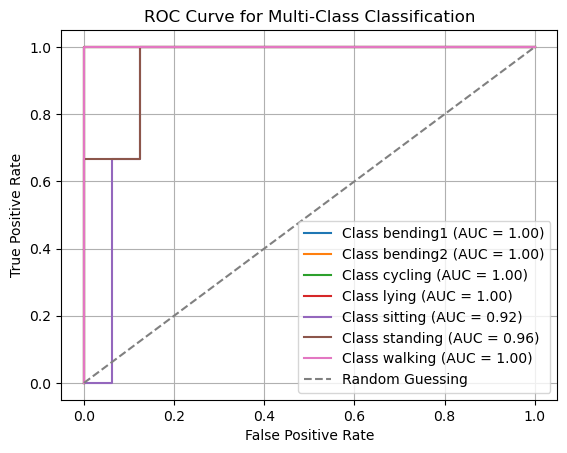

In [49]:
# finding confusion matrix, error, roc & auc for test datawset
print("Accuracy and ROC Curve for Test Dataset\n")
l=1
#getting test dataset
test_td_feature_df=get_time_domain_features_multi_class(test_datasets,l,series_names,parameters,parameter_names)
test_x=test_td_feature_df.iloc[:, :-1]
test_y=test_td_feature_df.iloc[:,-1]
#using best classifier from above to predict class
y_pred_gnb = results_Gaussian_NB[min_l_nb_gaussian]['model'].predict(test_x)
y_probs_gnb = results_Gaussian_NB[min_l_nb_gaussian]['model'].predict_proba(test_x)
cm = confusion_matrix(test_y, y_pred_gnb)
print("\n Confusion matrix : \n",cm)
test_accuracy_gnb = accuracy_score(test_y, y_pred_gnb)
test_error_gnb=1-test_accuracy_gnb
print("Test accuracy is :",round(test_accuracy_gnb,5))
print("Test error rate is :",round(test_error_gnb,5))
roc_auc_scores = []
for index,activity in enumerate(test_datasets):
    # For each class, create a binary target vector indicating whether the class is the positive class
    true_y = np.array([1 if label == activity else 0 for label in test_y])
    # Compute the ROC AUC score for the current class
    roc_auc = roc_auc_score(true_y, y_probs_gnb[:, index])
    roc_auc_scores.append(roc_auc)
    # roc curve for current class
    fpr, tpr, _ = roc_curve(true_y, y_probs_gnb[:, index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {activity} (AUC = {roc_auc:.2f})')
    
# Compute the average ROC AUC score across all classes
avg_roc_auc = np.mean(roc_auc_scores)
print("Average ROC AUC Score:", round(avg_roc_auc,5))

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Multinomial NB

In [50]:
# Variable assignment 
series_names=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
parameters = ['mean', '50%', 'std']
parameter_names=['mean','median','std']
folds=5
results_multinomial_NB={} 
# looping through different values of l(dataset split)
for l in range(1,21):
    train_td_feature_df=get_time_domain_features_multi_class(train_datasets,l,series_names,parameters,parameter_names)
    train_x=train_td_feature_df.iloc[:, :-1]
    train_y=train_td_feature_df.iloc[:,-1]
    # initializing stratified K folds for cross validation
    validator = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 14)
    # fitting gaussian NB
    results_multinomial_NB[l]={}
    model = MultinomialNB()
    model.fit(train_x,train_y)
    cv_accuracy = np.mean(cross_val_score(model, train_x, train_y, cv=validator,scoring='accuracy'))
    cv_error=1-cv_accuracy
    results_multinomial_NB[l]['cv error']=cv_error
    results_multinomial_NB[l]['cv accuracy']=cv_accuracy
    results_multinomial_NB[l]['model']=model

In [51]:
#printing results
result_dict_print_multinomial_NB={'L':results_multinomial_NB.keys() , 'cv error': [results_multinomial_NB[x]['cv error'] for x in range(1, 21)], 'cv accuracy':[results_multinomial_NB[x]['cv accuracy'] for x in range(1, 21)]}
pd.DataFrame(result_dict_print_multinomial_NB)

L  cv error  cv accuracy
0    1  0.159341     0.840659
1    2  0.143956     0.856044
2    3  0.173626     0.826374
3    4  0.158242     0.841758
4    5  0.187912     0.812088
5    6  0.172527     0.827473
6    7  0.202198     0.797802
7    8  0.202198     0.797802
8    9  0.230769     0.769231
9   10  0.230769     0.769231
10  11  0.245055     0.754945
11  12  0.202198     0.797802
12  13  0.230769     0.769231
13  14  0.202198     0.797802
14  15  0.216484     0.783516
15  16  0.245055     0.754945
16  17  0.245055     0.754945
17  18  0.216484     0.783516
18  19  0.259341     0.740659
19  20  0.245055     0.754945

In [52]:
min_l_nb_multinomial=None
min_error_nb_multinomial=float('inf')
for l in results_multinomial_NB:
    if min_error_nb_multinomial>results_multinomial_NB[l]['cv error']:
        min_error_nb_multinomial=results_multinomial_NB[l]['cv error']
        min_l_nb_multinomial=l

print('L with minimum cv error is:',min_l_nb_multinomial)
print('cv error is:',round(min_error_nb_multinomial,4))
print('cv accuracy is:',round(results_multinomial_NB[min_l_nb_multinomial]['cv accuracy'],4))

L with minimum cv error is: 2
cv error is: 0.144
cv accuracy is: 0.856


#### Confusion matrix, ROC for training dataset

Accuracy and ROC Curve for Training Dataset


 Confusion matrix : 
 [[ 4  0  0  0  1  0  0]
 [ 1  3  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  1 10  0  0]
 [ 0  0  0  0  2 10  0]
 [ 0  0  0  0  0  0 12]]
Train accuracy is : 0.91304
Train error rate is : 0.08696
Average ROC AUC Score: 0.99216


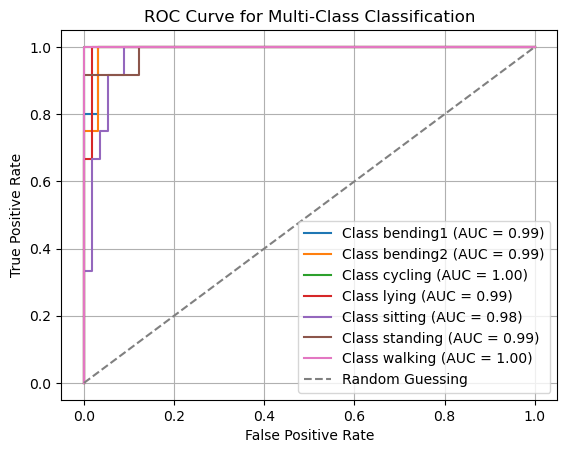

In [53]:
# finding confusion matrix, error, roc & auc for training datawset
print("Accuracy and ROC Curve for Training Dataset\n")
l=2
#getting training dataset
train_td_feature_df=get_time_domain_features_multi_class(train_datasets,l,series_names,parameters,parameter_names)
train_x=train_td_feature_df.iloc[:, :-1]
train_y=train_td_feature_df.iloc[:,-1]
#using best classifier from above to predict class
y_pred_mnb = results_multinomial_NB[min_l_nb_multinomial]['model'].predict(train_x)
y_probs_mnb = results_multinomial_NB[min_l_nb_multinomial]['model'].predict_proba(train_x)
cm = confusion_matrix(train_y, y_pred_mnb)
print("\n Confusion matrix : \n",cm)
train_accuracy_mnb = accuracy_score(train_y, y_pred_mnb)
train_error_mnb=1-train_accuracy_mnb
print("Train accuracy is :",round(train_accuracy_mnb,5))
print("Train error rate is :",round(train_error_mnb,5))
roc_auc_scores = []
for index,activity in enumerate(train_datasets):
    # For each class, create a binary target vector indicating whether the class is the positive class
    true_y = np.array([1 if label == activity else 0 for label in train_y])
    # Compute the ROC AUC score for the current class
    roc_auc = roc_auc_score(true_y, y_probs_mnb[:, index])
    roc_auc_scores.append(roc_auc)
    # roc curve for current class
    fpr, tpr, _ = roc_curve(true_y, y_probs_mnb[:, index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {activity} (AUC = {roc_auc:.2f})')
    
# Compute the average ROC AUC score across all classes
avg_roc_auc = np.mean(roc_auc_scores)
print("Average ROC AUC Score:", round(avg_roc_auc,5))

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Confusion matrix, ROC for test dataset

Accuracy and ROC Curve for Test Dataset


 Confusion matrix : 
 [[2 0 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
Test accuracy is : 0.84211
Test error rate is : 0.15789
Average ROC AUC Score: 0.97917


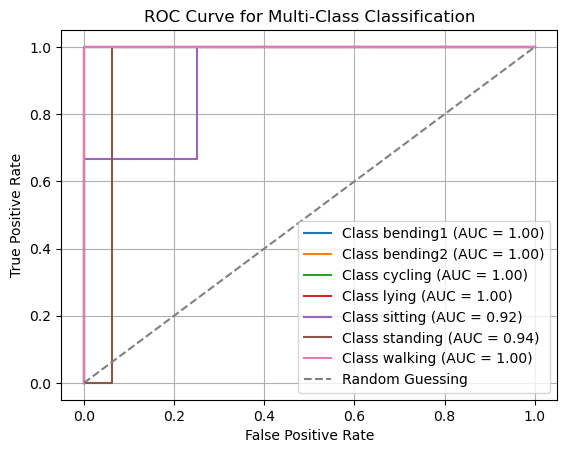

In [54]:
# finding confusion matrix, error, roc & auc for test datawset
print("Accuracy and ROC Curve for Test Dataset\n")
l=2
#getting test dataset
test_td_feature_df=get_time_domain_features_multi_class(test_datasets,l,series_names,parameters,parameter_names)
test_x=test_td_feature_df.iloc[:, :-1]
test_y=test_td_feature_df.iloc[:,-1]
#using best classifier from above to predict class
y_pred_mnb = results_multinomial_NB[min_l_nb_multinomial]['model'].predict(test_x)
y_probs_mnb = results_multinomial_NB[min_l_nb_multinomial]['model'].predict_proba(test_x)
cm = confusion_matrix(test_y, y_pred_mnb)
print("\n Confusion matrix : \n",cm)
test_accuracy_mnb = accuracy_score(test_y, y_pred_mnb)
test_error_mnb=1-test_accuracy_gnb
print("Test accuracy is :",round(test_accuracy_mnb,5))
print("Test error rate is :",round(test_error_mnb,5))
roc_auc_scores = []
for index,activity in enumerate(test_datasets):
    # For each class, create a binary target vector indicating whether the class is the positive class
    true_y = np.array([1 if label == activity else 0 for label in test_y])
    # Compute the ROC AUC score for the current class
    roc_auc = roc_auc_score(true_y, y_probs_mnb[:, index])
    roc_auc_scores.append(roc_auc)
    # roc curve for current class
    fpr, tpr, _ = roc_curve(true_y, y_probs_mnb[:, index])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {activity} (AUC = {roc_auc:.2f})')
    
# Compute the average ROC AUC score across all classes
avg_roc_auc = np.mean(roc_auc_scores)
print("Average ROC AUC Score:", round(avg_roc_auc,5))

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')

# Set plot labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Findings

1. Test error rate for both gaussian and Multinomial Naive Bayes classifiers are equal at 84.2%
2. Train error rate for gaussian NB is slightly better at 96% vs 91% from multinomial. Hence gaussian NB is a slighty better classifier for the given dataset

#### iiI. Comparison

Both test and training dataset **accuracies and ROC are highest with L1 penalized logistic regression** than Gaussian / Multinomial Naive Bayes classifiers. Hence L1 penalized logistic regression is the best classifier for this dataset

## 3. ISLR 4.8.3

The posterior probability of the k-th class:
$$p_k(x) = \frac {\pi_k \frac {1} {\sqrt{2 \pi} \sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_k)^2) } {\sum { \pi_l \frac {1} {\sqrt{2 \pi} \sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_l)^2) }}$$

The following terms in the expression above are independent w.r.t to k-th class:
$$Ind. Terms = \frac { \frac {1} {\sqrt{2 \pi}}} {\sum { \pi_l \frac {1} {\sqrt{2 \pi} \sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_l)^2) }}$$

Hence the maximizing probability is dependent only on, 
$$Max p_k(x) = \frac{\pi_k}{\sigma_k} \exp(- \frac {1} {2 \sigma_k^2} (x - \mu_k)^2)$$
  
Taking log of both sides
$$log(Max p_k(x)) = log(\pi_k) - log(\sigma_k) + (- \frac {1} {2 \sigma_k^2} (x - \mu_k)^2)$$
  
$$log(Maxp_k(x)) = (- \frac {1} {2 \sigma_k^2} (x^2 + \mu_k^2 - 2x\mu_k)) + log(\pi_k) - log(\sigma_k) $$
  
We have a squared term of x in the equation above. Hence, the decision boundary is non linear

## 4. ISLR 4.8.7



Based on Bayes’ therorem:

$$Pr(Y=Yes|X=x)=\frac{\pi_1 f_1(x)}{\sum_{l=1}^2\pi_l f_l(x)}$$

here, $f_i(x) = \frac{1}{\sqrt{2\pi\sigma_i^2}}e^{\frac{-1}{2\sigma_i^2}(x - \mu_i)^2}$ 

From the question we know that
$\pi_1 = 0.8, \pi_2 = 0.2,$
$\mu_1=10, \mu_2=0$, x=4
<br>Pluggin all values into the equation: 

$$Pr(Y=Yes|X=x) = \frac{0.8e^{\frac{-1}{2*36}(4 - 10)^2}}{0.8e^{\frac{-1}{2*36}(4 - 10)^2} + 0.2e^{\frac{-1}{2*36}(4 - 0)^2}}$$

$$Pr(Y=Yes|X=x) = 0.7519$$
